In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import nltk
from nltk.tokenize import sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import sklearn
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Upgrad/train.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [ ]:
df.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [ ]:
df["label"].value_counts()

1    10413
0    10387
Name: label, dtype: int64

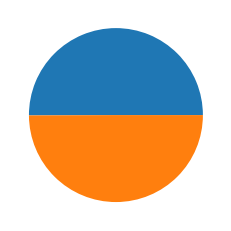

In [ ]:
plt.pie(df["label"].value_counts().values,data = ["Fake News","Real News"])
plt.show()
#the data given is balanced

In [ ]:
df = df.dropna()

In [ ]:
df.isnull().sum()

id        0
title     0
author    0
text      0
label     0
dtype: int64

In [ ]:
df_cp = df

In [ ]:
df_cp["title_author"] = df["title"] +" " + df["author"]

In [ ]:
df_cp["title_author"] = df_cp["title_author"].astype(str)

In [ ]:
df_cp = df_cp.drop(["title","author","text"],axis =1 )
df_cp

,id,label,title_author
0,0,1,House Dem Aide: We Didn’t Even See Comey’s Let...
1,1,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ..."
2,2,1,Why the Truth Might Get You Fired Consortiumne...
3,3,1,15 Civilians Killed In Single US Airstrike Hav...
4,4,1,Iranian woman jailed for fictional unpublished...
...,...,...,...
20795,20795,0,Rapper T.I.: Trump a ’Poster Child For White S...
20796,20796,0,"N.F.L. Playoffs: Schedule, Matchups and Odds -..."
20797,20797,0,Macy’s Is Said to Receive Takeover Approach by...
20798,20798,1,"NATO, Russia To Hold Parallel Exercises In Bal..."


In [ ]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
#Tokenizing df_cp
df_cp["title_author"] = df_cp.apply(lambda row: nltk.word_tokenize(row['title_author']), axis=1)
#Getting stop words from the library
stop = stopwords.words('english')
#Removing Stopping words
df_cp['title_author'] = df_cp['title_author'].apply(lambda x: [i for i in x if i not in stop])
#Removing punctuatio_marks
punctuation = [".",",",";",":","[","]","{","}","'","!","-","/",]
df_cp['title_author'] = df_cp['title_author'].apply(lambda x: [i for i in x if i not in punctuation])
#debugging
df_cp.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,id,label,title_author
0,0,1,"[House, Dem, Aide, We, Didn, ’, Even, See, Com..."
1,1,0,"[FLYNN, Hillary, Clinton, Big, Woman, Campus, ..."
2,2,1,"[Why, Truth, Might, Get, You, Fired, Consortiu..."
3,3,1,"[15, Civilians, Killed, In, Single, US, Airstr..."
4,4,1,"[Iranian, woman, jailed, fictional, unpublishe..."


In [ ]:
def pre_processing_testing(test_news):
  test_news = test_news.apply(lambda row: nltk.word_tokenize(row))
  stop = stopwords.words('english')
  test_news = test_news.apply(lambda x: [i for i in x if i not in stop])
  punctuation = [".",",",";",":","[","]","{","}","'","!","-","/",]
  df_cp['title_author'] = df_cp['title_author'].apply(lambda x: [i for i in x if i not in punctuation])
  return test_news


In [ ]:
df_cp["title_author"].apply(len).mean()

13.86420563303254

In [ ]:
X = df_cp["title_author"]
y = df_cp["label"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3)

In [ ]:
X_train.shape

(12799,)

In [ ]:
embed = hub.load("https://tfhub.dev/google/Wiki-words-250/2")

#Convert each series of words to a word2vec embedding
indiv = []
for i in X_train:
  temp = np.array(embed(i))
  indiv.append(temp)
indiv2 = []
for i in X_test:
  temp = np.array(embed(i))
  indiv2.append(temp)
print(type(indiv2))
#Accounts for different length of words
indiv = tf.keras.preprocessing.sequence.pad_sequences(indiv,dtype='float')
indiv2 = tf.keras.preprocessing.sequence.pad_sequences(indiv2,dtype='float')
indiv.shape

<class 'list'>


(12799, 69, 250)

In [ ]:
indiv2.shape

(5486, 57, 250)

In [ ]:

#Sequential model has a 50 cell LSTM layer before Dense layers
model = tf.keras.models.Sequential()


model.add(tf.keras.layers.LSTM(50))
model.add(tf.keras.layaers.Dense(20,activation='relu'))
model.add(tf.keras.layers.Dense(5,activation='relu'))

model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

#Compile model with binary_crossentropy loss, Adam optimizer, and accuracy metrics
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-4),
              loss="binary_crossentropy", metrics=['accuracy'])

#Train model on 10 epochs
model.fit(indiv, y_train,validation_data=[indiv2,y_test], epochs=10)

Epoch 1/10
400/400 [==============================] - 30s 68ms/step - loss: 0.5031 - accuracy: 0.8172 - val_loss: 0.2942 - val_accuracy: 0.8841
Epoch 2/10
400/400 [==============================] - 21s 53ms/step - loss: 0.2393 - accuracy: 0.9035 - val_loss: 0.2095 - val_accuracy: 0.9176
Epoch 3/10
400/400 [==============================] - 22s 54ms/step - loss: 0.1875 - accuracy: 0.9248 - val_loss: 0.1759 - val_accuracy: 0.9306
Epoch 4/10
400/400 [==============================] - 21s 53ms/step - loss: 0.1607 - accuracy: 0.9336 - val_loss: 0.1785 - val_accuracy: 0.9276
Epoch 5/10
400/400 [==============================] - 22s 55ms/step - loss: 0.1460 - accuracy: 0.9397 - val_loss: 0.1441 - val_accuracy: 0.9442
Epoch 6/10
400/400 [==============================] - 21s 52ms/step - loss: 0.1337 - accuracy: 0.9448 - val_loss: 0.1444 - val_accuracy: 0.9417
Epoch 7/10
400/400 [==============================] - 21s 53ms/step - loss: 0.1252 - accuracy: 0.9497 - val_loss: 0.1308 - val_accuracy:

In [ ]:
test_news=pd.Series(["Donald Trump sent his own plane to transport 200 stranded marines",
"FBI director received millions from Clinton Foundation, his brother’s law firm does Clinton’s taxes",
"Pope Francis shocks world, endorses Donald Trump for president",
"Ghost of Kyiv killed in fighting, has shot down 40 Russian jets","Russia Returns Bodies Of 62 Ukraine Soldiers After Difficult Negotiations",
 "Israel PM Hails 'Historic Agreement' With Lebanon On Sea Border",
 "Queen Consort Camilla Wants Meghan Markle, Prince Harry To Return To Royal Family: Report",
 "Silicon Valley Billionaire Yuri Milner Renounces Russian Citizenship"
 ])
print(test_news.shape)

test_news = test_news.apply(lambda row: nltk.word_tokenize(row))
stop = stopwords.words('english')
test_news = test_news.apply(lambda x: [i for i in x if i not in stop])
punctuation = [".",",",";",":","[","]","{","}","'","!","-","/",]
test_news = test_news.apply(lambda x: [i for i in x if i not in punctuation])

test_news

(8,)


0    [Donald, Trump, sent, plane, transport, 200, s...
1    [FBI, director, received, millions, Clinton, F...
2    [Pope, Francis, shocks, world, endorses, Donal...
3    [Ghost, Kyiv, killed, fighting, shot, 40, Russ...
4    [Russia, Returns, Bodies, Of, 62, Ukraine, Sol...
5    [Israel, PM, Hails, 'Historic, Agreement, With...
6    [Queen, Consort, Camilla, Wants, Meghan, Markl...
7    [Silicon, Valley, Billionaire, Yuri, Milner, R...
dtype: object

In [ ]:
test_news1 = []
for i in test_news:
  temp = np.array(embed(i))
  test_news1.append(temp)
test_news1 = tf.keras.preprocessing.sequence.pad_sequences(test_news1,dtype='float')

In [ ]:
test_news1.shape

(8, 14, 250)

In [ ]:
model.predict(test_news1)

1/1 [==============================] - 1s 562ms/step


array([[0.8460925 ],
       [0.8910343 ],
       [0.8347661 ],
       [0.90175915],
       [0.9543986 ],
       [0.9201529 ],
       [0.8512075 ],
       [0.84731644]], dtype=float32)

In [ ]:
#function for pre_processing
def pre_processing_input(test_case):
  test_news = test_case.apply(lambda row: nltk.word_tokenize(row))
  stop = stopwords.words('english')
  test_news = test_news.apply(lambda x: [i for i in x if i not in stop])
  punctuation = [".",",",";",":","[","]","{","}","'","!","-","/",]
  test_news = test_news.apply(lambda x: [i for i in x if i not in punctuation])
  return test_news



In [ ]:
#give the input function here and store it in below

#test_case =
test_case = pre_processing_input(pd.Series(test_case))


0    [Donald, Trump, sent, plane, transport, 200, s...
dtype: object